# Finetuned Full Analysis Stromal Embedded  

- Finetuning on a subset of the stromal cells to improve the model and the performance of the annotation 
- The full analysis notebook of the stromal cells can be found at: notebooks/full_analysis_stromal_embedded.ipynb

The dataset we are using is the same as the one used before. 
- The dataset can be found at: \scGPT\Stromal_cells_all_non-immune_cells_embedded.h5ad



In [1]:
#Finetuning to improve the model and the performance of the model 

#first, we load in all the data and ensure that the preprocessing is correct 

# Packages 
# %%
import copy
import gc
import json
import os
from pathlib import Path
import shutil
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import pickle
import torch
from anndata import AnnData
import scanpy as sc
#import scvi
import seaborn as sns
import numpy as np
#import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from sklearn.metrics import confusion_matrix

import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scgpt\model\model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scgpt\model\multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scanpy\_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [2]:
def setup_directories():
    """Set up necessary directories and paths"""
    repo_dir = Path.cwd().parent.absolute()
    data_dir = repo_dir / "data"
    save_dir = repo_dir / "save"
    
    # Create directories if they don't exist
    data_dir.mkdir(parents=True, exist_ok=True)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    return repo_dir, data_dir, save_dir

# Set up directories
repo_dir, data_dir, save_dir = setup_directories()

#show the directories 
print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Save directory: {save_dir}")

# Check if repo_dir is in sys.path
if str(repo_dir) not in sys.path:
    print(f"Adding {repo_dir} to system path")
    sys.path.append(str(repo_dir))
else:
    print(f"{repo_dir} already in system path")


#model dir append
model_dir = data_dir / "scGPT_CP" #use the same model as without finetuning 
# Check files in model_dir
print("Files in model directory:")
if model_dir.exists():
    for file in model_dir.iterdir():
        print(f"- {file.name} (Size: {file.stat().st_size / (1024 * 1024):.2f} MB)")
else:
    print("Model directory does not exist")






Repository directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT
Data directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\data
Save directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\save
Adding c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT to system path
Files in model directory:
- args.json (Size: 0.00 MB)
- best_model.pt (Size: 198.23 MB)
- vocab.json (Size: 1.26 MB)


## Setup configurations for training and for the data

This will be done later, but we will put here elements like hyperparameters, config, etc. 


In [3]:
hyperparameters = {
    # filled up later  
}

#create config file 



In [4]:
# settings for input and preproccessing 

# setup for input and output representations  

# settings for training 

# settings for the optimizer

# settings for the model 

# settings for evaluation and also for graphs etc 

# settings for saving and logging 

In [5]:
# validate the settings 

In [4]:
file_path = data_dir / "Stromal_cells_all_non-immune_cells_embedded.h5ad"
print (sc.read(file_path))

#embedded_data = sc.read(r"C:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\Stromal_cells_all_non-immune_cells_embedded.h5ad")


AnnData object with n_obs × n_vars = 61525 × 24256
    obs: 'mapped_reference_annotation', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'tissue_type', 'suspension_derivation_process', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nucleosome_signal', 'TSS.enrichment', 'onset', 'duration', 'lateralization', 'histological_assessment', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'vf_vst_counts.G120_N.1_mean', 'vf_vst_counts.G120_N.1_variance', 'vf_vst_counts.G120

# Load and pre-process the data 

In [ ]:
import requests
from tqdm import tqdm
import pandas as pd
from pathlib import Path

# Current dataset info: 
# At some point we can make this nicer, either with hyperparameters or with a config file, but it works for now 
dataset_name = 'Stromal_cells_all_non-immune_cells_embedded'
dataset_download_url = "https://datasets.cellxgene.cziscience.com/617749e2-71cb-428f-9eb7-bad1cf7988ef.h5ad"
dataset_id = "617749e2-71cb-428f-9eb7-bad1cf7988ef"
file_path = data_dir / "Stromal_cells_all_non-immune_cells_embedded.h5ad"

# Create tracking file if it doesn't exist
tracking_file = data_dir / 'dataset_tracking.csv'
if not tracking_file.exists():
    print(f"Creating tracking file {tracking_file}")
    pd.DataFrame(columns=['name', 'path', 'last_used', 'times_used', 'dataset_id', 'dataset_url']).to_csv(tracking_file, index=False)

# Download with progress bar if file doesn't exist
if not file_path.exists():
    print(f"Downloading {dataset_name} from {dataset_download_url} to {file_path}")
    response = requests.get(dataset_download_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_path, 'wb') as file, tqdm(total=total_size, unit='B', unit_scale=True) as pbar:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
            pbar.update(len(chunk))

df = pd.read_csv(tracking_file)

if str(file_path) in df['path'].values:
    # Update existing entry
    # Check if this file was already accessed in the last hour to avoid duplicate counts
    last_access = pd.to_datetime(df.loc[df['path'] == str(file_path), 'last_used'].iloc[0])
    if pd.Timestamp.now() - last_access < pd.Timedelta(hours=6):
        print("File accessed within the last hour - skipping increment")
    else:
        mask = df['path'] == str(file_path)
        df.loc[mask, 'times_used'] = df.loc[mask, 'times_used'].fillna(0) + 1
        df.loc[mask, 'last_used'] = pd.Timestamp.now()
else:
    # Add new entry (either for newly downloaded or existing untracked file)
    print (f"Adding new entry for {dataset_name} to tracking file")
    new_row = {'name': dataset_name, 'path': str(file_path), 
               'last_used': pd.Timestamp.now(), 'times_used': 1, 
               'dataset_id': dataset_id, 'dataset_url': dataset_download_url}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

df.to_csv(tracking_file, index=False)
print("Tracking updated!")

#it didn't update tracked, need to fix this #maybe better to do since last restart of computer, or idk, something like that 

File accessed within the last hour - skipping increment
Tracking updated!


In [6]:

# Display the tracking CSV file contents
print("Current dataset tracking:")
tracking_df = pd.read_csv(tracking_file)
display(tracking_df[['name', 'path', 'last_used', 'times_used', 'dataset_id']])


Current dataset tracking:


,name,path,last_used,times_used,dataset_id
0,Bronchopulmonary_displasia,c:\Users\annel\OneDrive\Documenten\Machine Lea...,02:33.3,4,1a8ba781-a3d7-467e-913f-757af3b24168
1,Stromal_cells_all_non-immune_cells_embedded,c:\Users\annel\OneDrive\Documenten\Machine Lea...,2025-02-12 12:27:16.092070,1,617749e2-71cb-428f-9eb7-bad1cf7988ef


Open the adata object with scanpy, and do some first check and analysis before preprocessing for training

In [12]:
if 'adata' not in locals():
    adata = sc.read(file_path)

#check annotation keys 
from my_src.my_utils import check_annotation_keys
adata_keys = check_annotation_keys(adata)

#check the number of cells and features 
print (adata.shape)
print (adata_keys)

celltype = adata_keys['cell_type_keys'][0]
print (celltype)

gene_name = adata_keys['gene_keys'][0]




Checking cell type annotations in .obs:

✓ Found 'cell_type' with 15 unique values
Examples:
  1. L2/3 intratelencephalic projecting glutamatergic neuron
  2. endothelial cell
  3. glutamatergic neuron
  4. astrocyte
  5. pvalb GABAergic cortical interneuron
Top counts:
  oligodendrocyte: 17108 cells
  glutamatergic neuron: 8984 cells
  L2/3 intratelencephalic projecting glutamatergic neuron: 8686 cells
  astrocyte: 5347 cells
  microglial cell: 4674 cells

Checking gene annotations in .var:

✓ Found 'feature_name' with 24256 unique values
Examples:
  1. MIR1302-2HG
  2. FAM138A
  3. OR4F5
  4. OR4F29
  5. OR4F16

Checking highly variable gene annotations in .var:

⚠️ No HVG annotations found in .var columns

Checking additional metadata:
Available .uns keys: ['citation', 'default_embedding', 'schema_reference', 'schema_version', 'title']
Available .layers: []
(61525, 24256)
{'cell_type_keys': ['cell_type'], 'gene_keys': ['feature_name'], 'hvg_keys': []}
cell_type


Data statistics:
Min value: 0.00
Max value: 4.05
Mean value: 0.13
Fraction of zeros: 93.00%


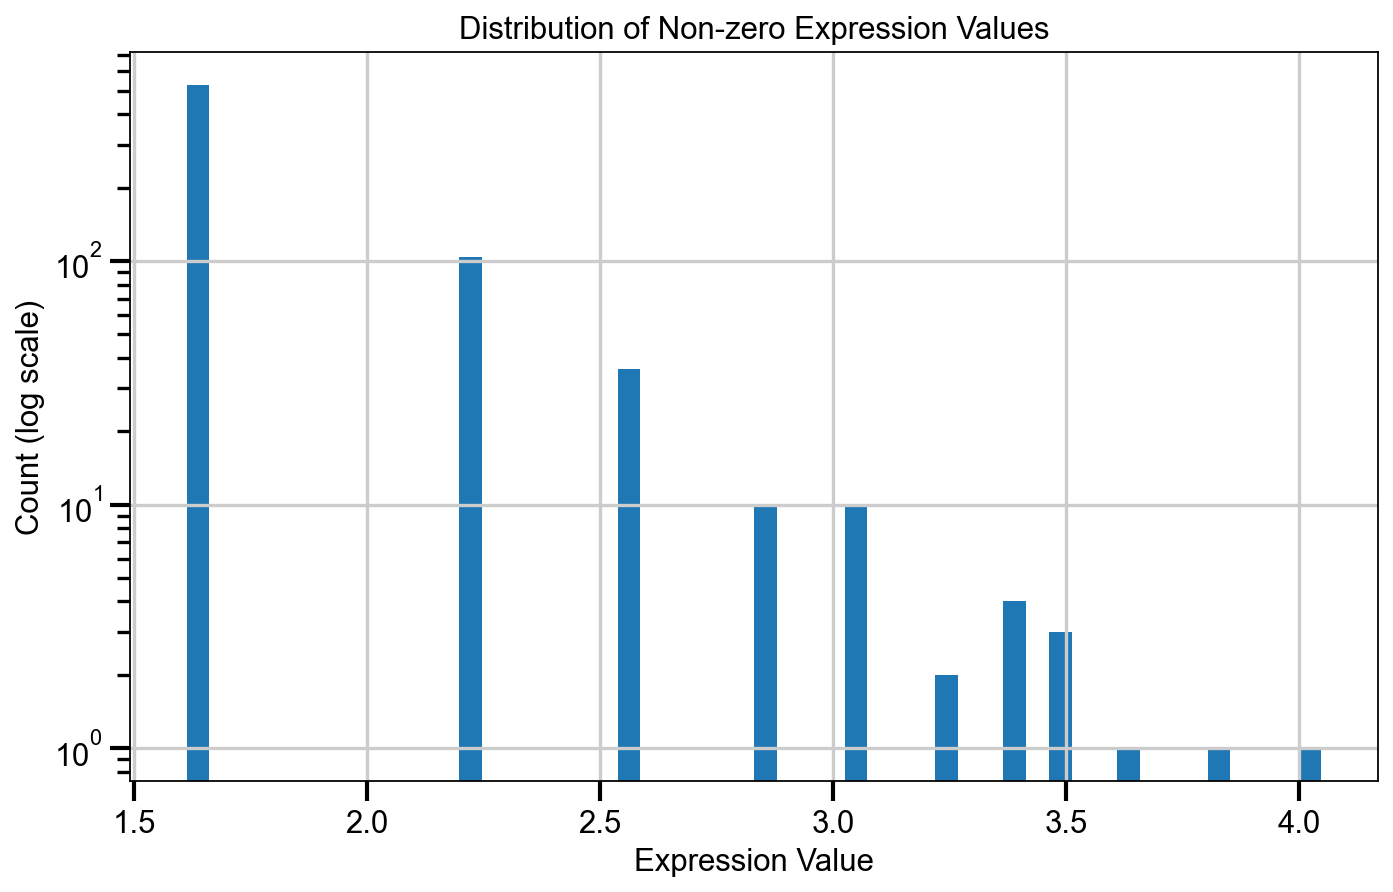


Normalization status:
Data appears to be normalized: True
Data appears to be log-transformed: False


In [9]:
# Check data normalization status
import numpy as np

# Get a sample of the data to check distribution
sample_data = adata.X.toarray().flatten()[:10000]  # Take first 10k values to avoid memory issues

# Calculate some statistics
data_min = np.min(sample_data)
data_max = np.max(sample_data)
zero_fraction = np.mean(sample_data == 0)
data_mean = np.mean(sample_data)

print("Data statistics:")
print(f"Min value: {data_min:.2f}")
print(f"Max value: {data_max:.2f}") 
print(f"Mean value: {data_mean:.2f}")
print(f"Fraction of zeros: {zero_fraction:.2%}")

# Plot histogram of non-zero values to check distribution
plt.figure(figsize=(10, 6))
plt.hist(sample_data[sample_data > 0], bins=50)
plt.yscale('log')
plt.title('Distribution of Non-zero Expression Values')
plt.xlabel('Expression Value') 
plt.ylabel('Count (log scale)')
plt.show()

# If data is normalized/log1p transformed:
# - Values should be relatively small (typically < 10)
# - Distribution should be roughly normal
# - Few extremely large values

is_normalized = data_max < 30 and 0 <= data_min
is_log = np.allclose(np.min(sample_data[sample_data > 0]), 0, atol=1e-3)

print("\nNormalization status:")
print(f"Data appears to be normalized: {is_normalized}")
print(f"Data appears to be log-transformed: {is_log}")


In [13]:
# First split the data into train/test based on donors
finetune_donors = ['G171', 'G150', 'G187']  # train donors
eval_donors = ['G133', 'G120', 'G210', 'G129', 'G159']  # test donors

# Create consistent labels (reversed from before)
adata.obs["is_ref"] = ["train" if donor in finetune_donors else "test" 
                      for donor in adata.obs["donor_id"]]
adata.obs["str_batch"] = pd.Categorical(["1" if donor in finetune_donors else "0"  # Reversed 0/1
for donor in adata.obs["donor_id"]])

adata.obs["batch_id"] = adata.obs["str_batch"].cat.codes

# Verify the split
print("\nSplit verification:")
print(pd.crosstab(adata.obs["donor_id"], [adata.obs["is_ref"], adata.obs["str_batch"]]))

celltype_id_labels = adata.obs[celltype].astype("category").cat.codes.values
celltypes = adata.obs[celltype].unique()

# Create mapping dictionary and store unique cell types
celltypes = adata.obs[celltype].unique()
num_types = len(celltypes)
print(f"Number of unique cell types: {num_types}")
adata.obs["celltype_id"] = celltype_id_labels
adata.var["gene_name"] = adata.var.index.tolist()
id2type = dict(enumerate(adata.obs[celltype].cat.categories))


# Calculate and print percentages for each donor
print("\nPercentage of cells per donor:")

train_cells = len(adata[adata.obs['is_ref'] == 'train'])
test_cells = len(adata[adata.obs['is_ref'] == 'test'])

ratio = test_cells / train_cells
print(f"Test to train ratio = {ratio:.0f}:1")

#some other specifications we need for the preprocessor
filter_gene_by_counts = False
data_is_raw = False 

#add an original copy later 



Split verification:
is_ref      test train
str_batch      0     1
donor_id              
G120       10824     0
G129        9141     0
G133       22237     0
G150           0  1650
G159        4266     0
G171           0  1151
G187           0  2880
G210        9376     0
Number of unique cell types: 15

Percentage of cells per donor:
Test to train ratio = 10:1


In [14]:
# Create a pandas DataFrame from adata.obs and display it
df = pd.DataFrame(adata.obs)
# This doesn't work because we need to pass a list of column names to select multiple columns
# The correct syntax is:
# Display sample of training data (batch_id 0) with key columns to verify splits
train_df = df[df["batch_id"] == 0][["celltype_id", "batch_id", celltype, "donor_id", "is_ref", "str_batch"]]
print("Sample of training data (batch_id 0):")
display(train_df.head(10))


Sample of training data (batch_id 0):


,celltype_id,batch_id,cell_type,donor_id,is_ref,str_batch
AAACCGCGTGCATTAG-1_1,13,0,L2/3 intratelencephalic projecting glutamaterg...,G120,test,0
AAAGGAGCAATCCTAG-1_1,0,0,endothelial cell,G120,test,0
AAAGGCTCATCCCGCT-1_1,13,0,L2/3 intratelencephalic projecting glutamaterg...,G120,test,0
AAATGCCTCTTGTTCG-1_1,13,0,L2/3 intratelencephalic projecting glutamaterg...,G120,test,0
AACAAAGGTTGTTCAC-1_1,13,0,L2/3 intratelencephalic projecting glutamaterg...,G120,test,0
AACATAGCATTAGCGC-1_1,0,0,endothelial cell,G120,test,0
AACCGGCTCTCGCCCA-1_1,4,0,glutamatergic neuron,G120,test,0
AACCTCCTCCTAGTTT-1_1,1,0,astrocyte,G120,test,0
AACCTTAAGGCTGTGC-1_1,13,0,L2/3 intratelencephalic projecting glutamaterg...,G120,test,0
AACCTTGCACATTGCA-1_1,4,0,glutamatergic neuron,G120,test,0


In [15]:
adata_train = adata[adata.obs['batch_id'] == 1]
adata_test = adata[adata.obs['batch_id'] == 0]

print(f"Training set: {len(adata_train)} cells")
print(f"Test set: {len(adata_test)} cells")
test_df = pd.DataFrame(adata_test.obs)
train_df = pd.DataFrame(adata_train.obs)

Training set: 5681 cells
Test set: 55844 cells


In [20]:
genes = adata.var["gene_name"].tolist() #list of genes 


In [16]:
n_bins = 51 #this will later be in the config file 

# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)



preprocessor(adata_train, batch_key=None)
preprocessor(adata_test, batch_key=None)

scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...


MemoryError: Unable to allocate 10.1 GiB for an array with shape (55844, 24256) and data type int64

In [ ]:
#input_style later added to the config and hyperparameters
input_style = "binned"

input_layer_key = {  # the values of this map coorespond to the keys in preprocessing
    "normed_raw": "X_normed",
    "log1p": "X_normed",
    "binned": "X_binned",
}[input_style]
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)

celltypes_labels = adata.obs["celltype_id"].tolist()  # make sure count from 0
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
)

KeyError: 'X_binned'

Configuration of the Model preparation

In [ ]:
load_model = model_dir

# settings for input and preprocessing --> This will be later in the config and the input settings
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = 0.0
mask_value = "auto"  # for masked values, now it should always be aut

if load_model is not None:
    print (f"load model is not None and found here: {model_dir}")
    model_dir = Path(load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    shutil.copy(vocab_file, save_dir / "vocab.json")
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var[gene_name]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    print(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    with open(model_config_file, "r") as f: 
        model_configs = json.load(f)
    print(
        f"Resume model from {model_file}, the model args will override the config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]

else: 
    vocab = Vocab(
    VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)


load model is not None and found here: {model_dir}
match 24256/24256 genes in vocabulary of size 60697.
Resume model from c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\data\scGPT_CP\best_model.pt, the model args will override the config c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\data\scGPT_CP\args.json.


## Tokenizer preparation 

In [ ]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=include_zero_gene,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=include_zero_gene,
)
print(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
print(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

In [ ]:
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    tensor_celltype_labels_train = torch.from_numpy(train_celltype_labels).long()
    tensor_celltype_labels_valid = torch.from_numpy(valid_celltype_labels).long()

    if sort_seq_batch:  # TODO: update to random pick seq source in each traning batch
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]
        tensor_celltype_labels_train = tensor_celltype_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]
        tensor_celltype_labels_valid = tensor_celltype_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
        "celltype_labels": tensor_celltype_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
        "celltype_labels": tensor_celltype_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    if num_workers == 0:
        num_workers = min(len(os.sched_getaffinity(0)), batch_size // 2)

    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader


In [ ]:
# Prepare the pre-trained model 

In this case we are using the continual pre-trained model since we did the same for the embeddings of the non-finetuned case. 